
# 🎯 최적 임계값(Threshold) 튜닝 + 예측 출력 (.ipynb)

이 노트북은 **GridSearch 재실행 없이**, 학습된 RF 모델을 사용해
- 교차검증 OOF 확률로 **F1이 최대가 되는 임계값 t\*** 를 찾고
- `predict_input.csv`에 동일 임계값을 적용하여 `predict_output.csv`(`SMILES`, `output`)를 생성합니다.

> 모델은 기존에 저장한 `rf_best_gridsearch.joblib`(권장) 또는 `rf_no_pca.joblib` 중 존재하는 파일을 자동으로 로드합니다.


In [1]:

# !pip install -q scikit-learn pandas numpy joblib matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import joblib

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, precision_recall_curve

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 공통 경로 확인
train_path = next((p for p in ["/mnt/data/train.csv","./train.csv","/content/train.csv"] if Path(p).exists()), None)
assert train_path, "train.csv 파일이 필요합니다."
print(f"[train] {train_path}")


[train] ./train.csv


## 1) 데이터 로드 & 피처 구성 (SMILES 제외, No PCA)

In [2]:

# 학습 데이터 로드
df = pd.read_csv(train_path)

# 라벨 정리
df['label_num'] = pd.to_numeric(df['label'], errors='coerce')
df = df[df['label_num'].isin([0,1])].copy()
y = df['label_num'].astype(int)

# 피처: SMILES 제외, 기본 물성 + 모든 fingerprint
exclude_cols = ['label','label_num','SMILES']
base_feats = [c for c in ['MolWt','clogp','sa_score','qed'] if c in df.columns]
fp_cols = [c for c in df.columns if any(k in c.upper() for k in ['ECFP','FCFP','PTFP'])]

feature_cols = base_feats + fp_cols
X = df[feature_cols].replace([np.inf,-np.inf], np.nan).fillna(0).to_numpy()

print(f"Samples: {X.shape[0]}, Features: {X.shape[1]}  (base={len(base_feats)}, fp={len(fp_cols)})")
print("Label distribution:\n", y.value_counts().sort_index())


Samples: 8349, Features: 3076  (base=4, fp=3072)
Label distribution:
 label_num
0    3807
1    4542
Name: count, dtype: int64


## 2) 학습된 모델 로드

In [3]:

model_path = None
candidates = ["/mnt/data/rf_best_gridsearch.joblib", "./rf_best_gridsearch.joblib",
              "/mnt/data/rf_no_pca.joblib", "./rf_no_pca.joblib", "/content/rf_no_pca.joblib"]
for p in candidates:
    if Path(p).exists():
        model_path = p
        break

assert model_path, "학습된 모델 파일(rf_best_gridsearch.joblib 또는 rf_no_pca.joblib)이 필요합니다."
rf = joblib.load(model_path)
print(f"[model] loaded: {model_path}")


[model] loaded: ./rf_best_gridsearch.joblib


## 3) OOF 확률 기반 임계값 스윕 (F1 최대 t*)

★ Best Threshold t* = 0.490 | OOF F1 = 0.8211


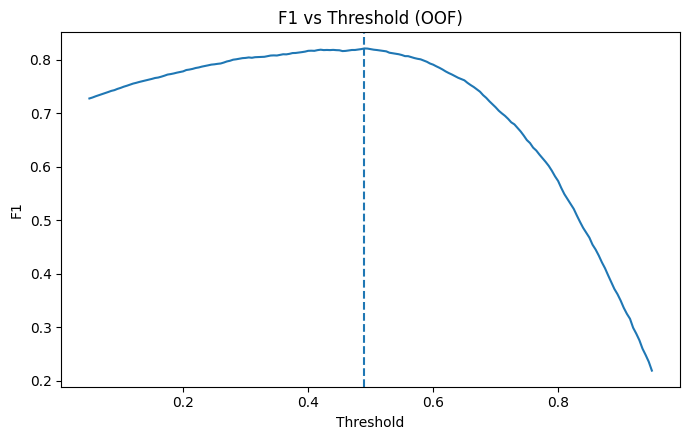

In [4]:

# OOF 확률 얻기 (모델을 각 폴드에서 새로 학습해 예측) — GridSearch 없이 빠르게
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_proba = cross_val_predict(rf, X, y, cv=cv, method="predict_proba")[:,1]

# 임계값 스윕
ts = np.linspace(0.05, 0.95, 181)  # 0.05~0.95 (step=0.005)
f1s = np.array([f1_score(y, (oof_proba >= t).astype(int)) for t in ts])

best_idx = int(np.argmax(f1s))
best_t = float(ts[best_idx])
best_f1 = float(f1s[best_idx])
print(f"★ Best Threshold t* = {best_t:.3f} | OOF F1 = {best_f1:.4f}")

# 시각화
plt.figure(figsize=(7,4.5))
plt.plot(ts, f1s)
plt.axvline(best_t, linestyle='--')
plt.title("F1 vs Threshold (OOF)")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.tight_layout()
plt.show()


## 4) predict_input.csv 예측 → predict_output.csv (SMILES, output)

In [5]:

# 예측 입력 로드
pred_path = next((p for p in ["/mnt/data/predict_input.csv","./predict_input.csv","/content/predict_input.csv"] if Path(p).exists()), None)
assert pred_path, "predict_input.csv 파일이 필요합니다."
pred_df = pd.read_csv(pred_path)
print(f"[predict_input] {pred_path}  shape={pred_df.shape}")

# 동일 전처리
X_base_pred = pred_df[base_feats].replace([np.inf,-np.inf], np.nan).fillna(0) if base_feats else None
X_fp_pred = pred_df[fp_cols].replace([np.inf,-np.inf], np.nan).fillna(0) if fp_cols else None

if X_base_pred is not None and X_fp_pred is not None:
    X_pred = np.hstack([X_base_pred.values, X_fp_pred.values])
elif X_fp_pred is not None:
    X_pred = X_fp_pred.values
elif X_base_pred is not None:
    X_pred = X_base_pred.values
else:
    raise ValueError("예측에 사용할 피처가 없습니다.")

# 확률 → 임계값 적용
proba_pred = rf.predict_proba(X_pred)[:,1]
pred_label = (proba_pred >= best_t).astype(int)

out_df = pd.DataFrame({
    "SMILES": pred_df["SMILES"],
    "output": pred_label
})
out_df.to_csv("predict_output.csv", index=False)
print("✅ 저장 완료: predict_output.csv")
out_df.head()


[predict_input] ./predict_input.csv  shape=(927, 3077)
✅ 저장 완료: predict_output.csv


c:\skala_workspace\RAG\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,SMILES,output
0,OC(=O)c1cc2sccc2[nH]1,1
1,[O-][n+]1onc(c2ccccc2)c1C#N,1
2,CN1C(=O)N(C)c2ncn(C)c2C1=O,1
3,Clc1cccc(c1)C2CNCC=CC2,1
4,CCN(CC)CC(=O)Nc1c(C)cccc1C,1
